## Implement utility classes and methods for knowledge base and model checking

In [29]:
import itertools

class Sentence():

    def evaluate(self, model):
        """Evaluates the logical sentence."""
        raise Exception("nothing to evaluate")

    def formula(self):
        """Returns string formula representing logical sentence."""
        return ""

    def symbols(self):
        """Returns a set of all symbols in the logical sentence."""
        return set()

    @classmethod
    def validate(cls, sentence):
        if not isinstance(sentence, Sentence):
            raise TypeError("must be a logical sentence")

    @classmethod
    def parenthesize(cls, s):
        """Parenthesizes an expression if not already parenthesized."""
        def balanced(s):
            """Checks if a string has balanced parentheses."""
            count = 0
            for c in s:
                if c == "(":
                    count += 1
                elif c == ")":
                    if count <= 0:
                        return False
                    count -= 1
            return count == 0
        if not len(s) or s.isalpha() or (
            s[0] == "(" and s[-1] == ")" and balanced(s[1:-1])
        ):
            return s
        else:
            return f"({s})"


class Symbol(Sentence):

    def __init__(self, name):
        self.name = name

    def __eq__(self, other):
        return isinstance(other, Symbol) and self.name == other.name

    def __hash__(self):
        return hash(("symbol", self.name))

    def __repr__(self):
        return self.name

    def evaluate(self, model):
        try:
            return bool(model[self.name])
        except KeyError:
            raise EvaluationException(f"variable {self.name} not in model")

    def formula(self):
        return self.name

    def symbols(self):
        return {self.name}


class Not(Sentence):
    def __init__(self, operand):
        Sentence.validate(operand)
        self.operand = operand

    def __eq__(self, other):
        return isinstance(other, Not) and self.operand == other.operand

    def __hash__(self):
        return hash(("not", hash(self.operand)))

    def __repr__(self):
        return f"Not({self.operand})"

    def evaluate(self, model):
        return not self.operand.evaluate(model)

    def formula(self):
        return "¬" + Sentence.parenthesize(self.operand.formula())

    def symbols(self):
        return self.operand.symbols()


class And(Sentence):
    def __init__(self, *conjuncts):
        for conjunct in conjuncts:
            Sentence.validate(conjunct)
        self.conjuncts = list(conjuncts)

    def __eq__(self, other):
        return isinstance(other, And) and self.conjuncts == other.conjuncts

    def __hash__(self):
        return hash(
            ("and", tuple(hash(conjunct) for conjunct in self.conjuncts))
        )

    def __repr__(self):
        conjunctions = ", ".join(
            [str(conjunct) for conjunct in self.conjuncts]
        )
        return f"And({conjunctions})"

    def add(self, conjunct):
        Sentence.validate(conjunct)
        self.conjuncts.append(conjunct)

    def evaluate(self, model):
        return all(conjunct.evaluate(model) for conjunct in self.conjuncts)

    def formula(self):
        if len(self.conjuncts) == 1:
            return self.conjuncts[0].formula()
        return " ∧ ".join([Sentence.parenthesize(conjunct.formula())
                           for conjunct in self.conjuncts])

    def symbols(self):
        return set.union(*[conjunct.symbols() for conjunct in self.conjuncts])


class Or(Sentence):
    def __init__(self, *disjuncts):
        for disjunct in disjuncts:
            Sentence.validate(disjunct)
        self.disjuncts = list(disjuncts)

    def __eq__(self, other):
        return isinstance(other, Or) and self.disjuncts == other.disjuncts

    def __hash__(self):
        return hash(
            ("or", tuple(hash(disjunct) for disjunct in self.disjuncts))
        )

    def __repr__(self):
        disjuncts = ", ".join([str(disjunct) for disjunct in self.disjuncts])
        return f"Or({disjuncts})"

    def evaluate(self, model):
        return any(disjunct.evaluate(model) for disjunct in self.disjuncts)

    def formula(self):
        if len(self.disjuncts) == 1:
            return self.disjuncts[0].formula()
        return " ∨  ".join([Sentence.parenthesize(disjunct.formula())
                            for disjunct in self.disjuncts])

    def symbols(self):
        return set.union(*[disjunct.symbols() for disjunct in self.disjuncts])


class Implication(Sentence):
    def __init__(self, antecedent, consequent):
        Sentence.validate(antecedent)
        Sentence.validate(consequent)
        self.antecedent = antecedent
        self.consequent = consequent

    def __eq__(self, other):
        return (isinstance(other, Implication)
                and self.antecedent == other.antecedent
                and self.consequent == other.consequent)

    def __hash__(self):
        return hash(("implies", hash(self.antecedent), hash(self.consequent)))

    def __repr__(self):
        return f"Implication({self.antecedent}, {self.consequent})"

    def evaluate(self, model):
        return ((not self.antecedent.evaluate(model))
                or self.consequent.evaluate(model))

    def formula(self):
        antecedent = Sentence.parenthesize(self.antecedent.formula())
        consequent = Sentence.parenthesize(self.consequent.formula())
        return f"{antecedent} => {consequent}"

    def symbols(self):
        return set.union(self.antecedent.symbols(), self.consequent.symbols())


class Biconditional(Sentence):
    def __init__(self, left, right):
        Sentence.validate(left)
        Sentence.validate(right)
        self.left = left
        self.right = right

    def __eq__(self, other):
        return (isinstance(other, Biconditional)
                and self.left == other.left
                and self.right == other.right)

    def __hash__(self):
        return hash(("biconditional", hash(self.left), hash(self.right)))

    def __repr__(self):
        return f"Biconditional({self.left}, {self.right})"

    def evaluate(self, model):
        return ((self.left.evaluate(model)
                 and self.right.evaluate(model))
                or (not self.left.evaluate(model)
                    and not self.right.evaluate(model)))

    def formula(self):
        left = Sentence.parenthesize(str(self.left))
        right = Sentence.parenthesize(str(self.right))
        return f"{left} <=> {right}"

    def symbols(self):
        return set.union(self.left.symbols(), self.right.symbols())


def model_check(knowledge, query):
    """Checks if knowledge base entails query."""

    def check_all(knowledge, query, symbols, model):
        """Checks if knowledge base entails query, given a particular model."""

        # If model has an assignment for each symbol
        if not symbols:

            # If knowledge base is true in model, then query must also be true
            if knowledge.evaluate(model):
                return query.evaluate(model)
            return True
        else:

            # Choose one of the remaining unused symbols
            remaining = symbols.copy()
            p = remaining.pop()

            # Create a model where the symbol is true
            model_true = model.copy()
            model_true[p] = True

            # Create a model where the symbol is false
            model_false = model.copy()
            model_false[p] = False

            # Ensure entailment holds in both models
            return (check_all(knowledge, query, remaining, model_true) and
                    check_all(knowledge, query, remaining, model_false))

    # Get all symbols in both knowledge and query
    symbols = set.union(knowledge.symbols(), query.symbols())

    # Check that knowledge entails query
    return check_all(knowledge, query, symbols, dict())


## Example 1 - What did Harry Potter do to day?

Consider the following sentences:

1. If it didn’t rain, Harry visited Hagrid today.
2. Harry visited Hagrid or Dumbledore today, but not both.
3. Harry visited Dumbledore today.

Construct a knowledge base represents the knowledge above and use the knowledge base to answer the following question:
1. Was it rain today?
2. Did Harry visit Hagrid today?

In [ ]:
# Create new classes, each having a name, or a symbol, representing each proposition.
rain = Symbol("rain")       # It was raining.
hagrid = Symbol("hagrid")   # Harry visited Hagrid
dumbledore = Symbol("dumbledore") # Harry visited Dumbledore

knowledge = And(  # Starting from the "And" logical connective, becasue each proposition represents knowledge that we know to be true.
    Implication(Not(rain), hagrid), # ¬(It is raining) → (Harry visited Hagrid)
    Or(hagrid, dumbledore),         # (Harry visited Hagrid) ∨ (Harry visited Dumbledore).
    Not(And(hagrid, dumbledore)),   # ¬(Harry visited Hagrid ∧ Harry visited Dumbledore) i.e. Harry did not visit both Hagrid and Dumbledore.
    dumbledore  # Harry visited Dumbledore. Note that while previous propositions contained multiple symbols with connectors,
                # this is a proposition consisting of one symbol. This means that we take as a fact that,
                # in this KB, Harry visited Dumbledore.
)

print("Was it rain today?", model_check(knowledge, rain))
print("Did Harry visit Hagrid today?", model_check(knowledge, hagrid))


Was it rain today? True
Did Harry visit Hagrid today? False


## Example 2 - A Quidditch

In a quidditch game, Harry can play seeker or beater for Gryffindor team. Ron can play either seeker or keeper, and Oliver always plays keeper. The game has only one seeker, two beater, and one keeper.
The Gryffindor team always lose when Ron plays keeper. However, the team won on last Sunday.

Create neccessary symbols to represent all the propositions above and construct a knowledge base that contains as much knowledge as possible.
Use the model checking on the knowledge base to answer the the following questions about the game on last Sunday:
1. Did Oliver play keeper?
2. Did Ron play keeper?
3. Did Ron play seeker?
4. Did Harry play seeker?
5. Did Harry play beater?

In [31]:
# Create new classes, each having a name, or a symbol, representing each proposition.
harrySeeker = Symbol("harrySeeker")   # Harry plays seeker
harryBeater = Symbol("harryBeater")   # Harry plays beater
ronSeeker = Symbol("ronSeeker")       # Ron plays seeker
ronKeeper = Symbol("ronKeeper")       # Ron plays keeper
oliverKeeper = Symbol("oliverKeeper")             # Oliver plays keeper
gryffindor = Symbol("gryffindor") # Gryffindor wins

knowledge = And(
    # Add statements to construct the knowledge base
    Or(harrySeeker, harryBeater),           # Harry can play seeker or beater
    Not(And(harrySeeker, harryBeater)),     # Harry can't play both seeker and beater in a game
    Or(ronSeeker, ronKeeper),               # Ron can play seeker or Keeper
    Not(And(ronSeeker, ronKeeper)),         # Ron can't play both seeker and keeper in a game
    
    Biconditional(harrySeeker, Not(ronSeeker)), # Only one seeker in the game (Harry or Ron)
    oliverKeeper,                           # Oliver always plays keeper
    
    Implication(ronKeeper, Not(gryffindor)),# If Ron plays keeper, Gryffindor won't win
    gryffindor                              # Gryffindor wins
)

# Answer the questions
print("Did Oliver play keeper?", model_check(knowledge, oliverKeeper))
print("Did Ron play keeper?", model_check(knowledge, ronKeeper))
print("Did Ron play seeker?", model_check(knowledge, ronSeeker))
print("Did Harry play seeker?", model_check(knowledge, harrySeeker))
print("Did Harry play beater?", model_check(knowledge, harryBeater))

Did Oliver play keeper? True
Did Ron play keeper? False
Did Ron play seeker? True
Did Harry play seeker? False
Did Harry play beater? True


## Example 3 - A textbook



A textbook is the be translated into at least one of seven languages: Arabic, Chinese, French, German, Hindi, Russian, and Spanish, according to the following conditions:

1.   If it is translated into French, it is translated into German.
2.   If it is translated into Arabic or Chinese or both, it will not be translated into Russian.
3. If it is not translated into Arabic, it is translated into Hindi.
4. If it is translated into Spanish, it will not be translated into German.

Assume that the textbook is translated into French and Russian, list all possible languages into which the textbook is translated.

In [32]:
arabic = Symbol("Arabic")     # Textbook is translated to Arabic
chinese = Symbol("Chinese")   # Textbook is translated to Chinese
french = Symbol("French")     # Textbook is translated to French
german = Symbol("German")     # Textbook is translated to German
hindi = Symbol("Hindi")       # Textbook is translated to Hindi
russian = Symbol("Russian")   # Textbook is translated to Russian
spanish = Symbol("Spanish")   # Textbook is translated to Spanish

knowledge = And(
    # Add statements to construct the knowledge base
    Implication(french, german),
    Implication(Or(arabic, chinese), Not(russian)),
    Implication(Not(arabic), hindi),
    Implication(spanish, Not(german)),
    
    # Known facts
    french,
    russian
)

# List all possible languages into which the textbook is translated
possible_languages = []
languages = [arabic, chinese, french, german, hindi, russian, spanish]

print("Checking which languages the textbook is translated into:")
for lang in languages:
    if model_check(knowledge, lang):
        print(f"- {lang.name}")

Checking which languages the textbook is translated into:
- French
- German
- Hindi
- Russian


## Example 4 - The Clue game


### Introduction
Clue (or Cluedo) is a classic detective board game. In Clue, a murder was committed by a *person*, using a *tool* in a *location*, and players move from room to room in a mansion to solve a murder mystery.

People, tools, and locations are represented by cards. One card of each category is picked at random and put in an envelope, and it is up to the participants to uncover who done it, with what, and where?.

Players must move to a room and then make a suggestion against a character saying they did it in that room with a specific weapon. The player to the left must show one of any cards mentioned if in that player's hand. Through deductive reasoning each player must figure out which character, weapon, and location are in the secret file.

To do this, each player must uncover what cards are in other players hands by making more and more suggestions. Once a player knows what cards the other players are holding, they will know what cards are in the secret file, and then make an accusation. If correct, the player wins, but if incorrect, the player must return the cards to the file without revealing them and may no longer make suggestions or accusations.

We will use the Model Checking algorithm from before to uncover the mystery. In our model, we mark as True items that we know are related to the murder and False otherwise.

For our purposes, suppose we have three people: *Mustard*, *Plum*, and *Scarlet*, three tools: *knife*, *revolver*, and *wrench*, and three locations: *ballroom*, *kitchen*, and *library*.

### Step 1
We can start creating our knowledge base by adding the rules of the game. We know for certain that one person is the murderer, that one tool was used, and that the murder happened in one location. This can be represented in propositional logic the following way:
  
(Mustard ∨ Plum ∨ Scarlet)

(knife ∨ revolver ∨ wrench)

(ballroom ∨ kitchen ∨ library)


In [33]:
mustard = Symbol("Mustard")
plum = Symbol("Plum")
scarlet = Symbol("Scarlet")
characters = [mustard, plum, scarlet]

ballroom = Symbol("ballroom")
kitchen = Symbol("kitchen")
library = Symbol("library")
rooms = [ballroom, kitchen, library]

knife = Symbol("knife")
revolver = Symbol("revolver")
wrench = Symbol("wrench")
weapons = [knife, revolver, wrench]

symbols = characters + rooms + weapons

# check for items (characters, rooms, weapons) that are related to the murder.
def check_knowledge(knowledge):
    for symbol in symbols:
        if model_check(knowledge, symbol):
            print(f"{symbol}: YES")
        elif not model_check(knowledge, Not(symbol)):
            print(f"{symbol}: MAYBE")

# There must be a person, room, and weapon.
knowledge = And(
    Or(mustard, plum, scarlet),
    Or(ballroom, kitchen, library),
    Or(knife, revolver, wrench)
)

check_knowledge(knowledge)

Mustard: MAYBE
Plum: MAYBE
Scarlet: MAYBE
ballroom: MAYBE
kitchen: MAYBE
library: MAYBE
knife: MAYBE
revolver: MAYBE
wrench: MAYBE


### Step 2
The game starts with each player seeing three cards: one person, one tool, and one location, thus knowing that they are not related to the murder. Players do not share the information that they saw in these cards.

Suppose our player gets the cards of *Mustard*, *kitchen*, and *revolver*. Thus, we know that these are not related to the murder and we can add the following proposition to our KB:

¬(Mustard)

¬(kitchen)

¬(revolver)

In [34]:
# Three initial cards
knowledge.add(And(
    Not(mustard), Not(kitchen), Not(revolver)
))

check_knowledge(knowledge)

Plum: MAYBE
Scarlet: MAYBE
ballroom: MAYBE
library: MAYBE
knife: MAYBE
wrench: MAYBE


### Step 3
In other situations in the game, one can make a guess, suggesting one combination of person, tool and location.

Suppose that the guess is that *Scarlet* used a *wrench* to commit the crime in the *library*. If this guess is wrong, then the following proposition can be deduced and added to the KB:

(¬Scarlet ∨ ¬library ∨ ¬wrench)

In [35]:
# Making a wrong guess
knowledge.add(Or(
    Not(scarlet), Not(library), Not(wrench)
))

check_knowledge(knowledge)

Plum: MAYBE
Scarlet: MAYBE
ballroom: MAYBE
library: MAYBE
knife: MAYBE
wrench: MAYBE


### Step 4
The game continues, and suppose that other players show us two cards: the *Plum* card and the *ballroom* card. Thus, we know that Mr *Plum* and the *ballroom* are not related to the murder. Then we can add the following proposition to our KB:

¬(Plum)

¬(ballroom)

In [36]:
# Known two cards
knowledge.add(Not(plum))
knowledge.add(Not(ballroom))

check_knowledge(knowledge)

Scarlet: YES
library: YES
knife: YES


And now, using multiple previous pieces of data, we can deduce that *Scarlet* committed the murder with a *knife* in the *library*.

We can conclude that the murderer is *Scarlet*, since it has to be one of *Mustard*, *Plum*, and *Scarlet*, and we have evidence that the first two are not the murdered.

We can deduce that it’s the *library* because it has to be either the *ballroom*, the *kitchen*, or the *library*, and the first two were proven to not be the locations.

However, when someone guessed *Scarlet*, *library*, *wrench*, the guess was false. Thus, at least one of the elements in this statement has to be false. Since we know both *Scarlet* and *library* to be true, we know that the *wrench* is the false part here.

Since one of the three instruments has to be true, and it’s not the *wrench* nor the *revolver*, we can conclude that it is the *knife*.

## Example 5 - The Mastermind game

### Introduction
Another type of puzzle that can be solved using propositional logic is a Mastermind game.

In this game, player one arranges colors in a certain order, and then player two has to guess this order.

Each turn, player two makes a guess, and player one gives back a number, indicating how many colors player two got right.

Let’s simulate a game with three colors. Suppose player two suggests the following ordering:

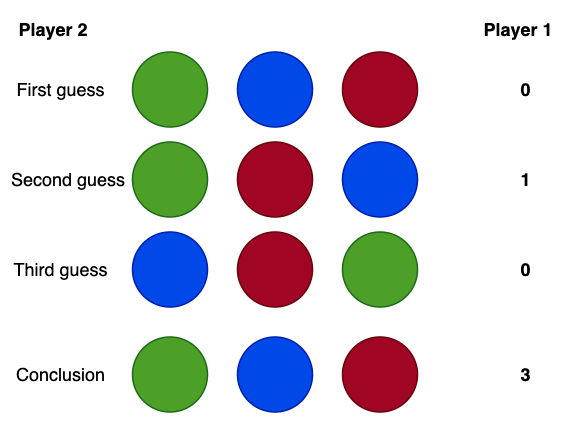

1.   In the first guess, the player two arranges three colors as GBR (Green Blue Red). The player one answers 0, thus the player two knows that there isn't any color which is in the correct position.
2.   Based on this information, player two tries to switch the locations of two colors in the second guess, GRB. The player one answer 1, thus we know that one color is in the correct position, and the other two are in the wrong place.
3.   The player two continue switching the locations of two colors in the third guess, BRG. The player one answer 0, which means no color is in the correct position. Through deductive reasoning, the player two will figure out the correct positions of the three colors.
4.   The player two concludes the correct positions of three colors, GBR. The player one answer 3, and the game is over.

### Simulation
Representing this game in propositional logic would require us to have (number of colors)² atomic propositions.

So, in the case of three colors, we would have the propositions red0, red1, red2, blue0, blue1, blue2, green0, green1, green2 … standing for color and position.

The next step would be representing the rules of the game in propositional logic (that there is only one color in each position and no colors repeat) and adding them to the KB.

The final step would be adding all the clues that we have to the KB. In our case, we would add that, in the first guess, no position was right, and in the second guess, two positions were wrong and one was right. In the third guess, none was right.

Using this knowledge, a Model Checking algorithm can give us the solution to the puzzle.

In [37]:
colors = ["red", "blue", "green"]

# Create necessary symbols: red0, red1, red2, blue0, blue1, blue2
# green0, green1, green2
symbols = []
for i in range(3):
    for color in colors:
        symbols.append(Symbol(f"{color}{i}"))

knowledge = And()

# Each color has a position.
for color in colors:
    knowledge.add(Or(
        Symbol(f"{color}0"),
        Symbol(f"{color}1"),
        Symbol(f"{color}2"),
    ))

# Only one position per color, for example:
# red0 -> Not(red1)
# red0 -> Not(red2)
for color in colors:
    for i in range(3):
        for j in range(3):
            if i != j:
                knowledge.add(Implication(
                    Symbol(f"{color}{i}"), Not(Symbol(f"{color}{j}"))
                ))

# Only one color per position, for example:
# red0 -> Not(blue0)
# red0 -> Not(green0)
for i in range(3):
    for c1 in colors:
        for c2 in colors:
            if c1 != c2:
                knowledge.add(Implication(
                    Symbol(f"{c1}{i}"), Not(Symbol(f"{c2}{i}"))
                ))

# The first guess
knowledge.add(And(
    Not(Symbol("green0")), Not(Symbol("blue1")), Not(Symbol("red2"))
))

# The second guess
knowledge.add(Or(
    And(Symbol("green0"), Not(Symbol("red1")), Not(Symbol("blue2"))),
    And(Symbol("red1"), Not(Symbol("green0")), Not(Symbol("blue2"))),
    And(Symbol("blue2"), Not(Symbol("green0")), Not(Symbol("red1")))
))

# The third guess
knowledge.add(And(
    Not(Symbol("blue0")), Not(Symbol("red1")), Not(Symbol("green2"))
))

check_knowledge(knowledge)

red0: YES
green1: YES
blue2: YES


## Exercise 1


Simulate the Clue game with four people: *Alice*, *Dave*, *Eddie*, and *Frida*; four tools: *rope*, *poison*, *bow*, and *dagger*; four locations: *garden*, *chamber*, *library* and *temple*.

The following steps should be simulated:

Step 1: Create knowledge base by adding the rules of the game

(Alice ∨ Dave ∨ Eddie ∨ Frida)

(rope ∨ poison ∨ bow ∨ dagger)

(garden ∨ chamber ∨ library ∨ temple)

Step 2: You gets three initial cards of: Dave, Libary, and Poison.

Step 3: Some players make the following wrong guesses:

*  *Alice* used a *rope* to commit the crime in the *garden*.
*  *Eddie* used a *dagger* to commit the crime in the *temple*.
*  *Frida* used a *bow* to commit the crime in the *garden*.
*  *Frida* used a *rope* to commit the crime in the *temple*.
*  *Eddie* used a *bow* to commit the crime in the *temple*.
*  *Eddie* used a *bow* to commit the crime in the *chamber*.

Step 4: Some players show the following cards: Alice, Dagger, Garden, Rope, Temple


In [38]:
# INSERT YOUR ANSWER HERE
# Define characters, rooms, and weapons
alice = Symbol("Alice")
dave = Symbol("Dave")
eddie = Symbol("Eddie")
frida = Symbol("Frida")
characters = [alice, dave, eddie, frida]

rope = Symbol("rope")
poison = Symbol("poison")
bow = Symbol("bow")
dagger = Symbol("dagger")
weapons = [rope, poison, bow, dagger]

garden = Symbol("garden")
chamber = Symbol("chamber")
library = Symbol("library")
temple = Symbol("temple")
rooms = [garden, chamber, library, temple]

symbols = characters + rooms + weapons

# check for items (characters, rooms, weapons) that are related to the murder.
def check_knowledge(knowledge):
    for symbol in symbols:
        if model_check(knowledge, symbol):
            print(f"{symbol}: YES")
        elif model_check(knowledge, Not(symbol)):
            print(f"{symbol}: NO")
        else:
            print(f"{symbol}: MAYBE")

# Step 1: Create knowledge base with game rules
knowledge = And(
    Or(alice, dave, eddie, frida),
    Or(rope, poison, bow, dagger),
    Or(garden, chamber, library, temple)
)

# Step 2: Add initial cards (they are NOT the solution)
knowledge.add(Not(dave))
knowledge.add(Not(library))
knowledge.add(Not(poison))

# Step 3: Add wrong guesses
# A wrong guess (A and B and C) means Not(And(A, B, C)), which is equivalent to Or(Not(A), Not(B), Not(C))
knowledge.add(Or(Not(alice), Not(rope), Not(garden)))
knowledge.add(Or(Not(eddie), Not(dagger), Not(temple)))
knowledge.add(Or(Not(frida), Not(bow), Not(garden)))
knowledge.add(Or(Not(frida), Not(rope), Not(temple)))
knowledge.add(Or(Not(eddie), Not(bow), Not(temple)))
knowledge.add(Or(Not(eddie), Not(bow), Not(chamber)))


# Step 4: Add cards shown by other players (they are NOT the solution)
knowledge.add(Not(alice))
knowledge.add(Not(dagger))
knowledge.add(Not(garden))
knowledge.add(Not(rope))
knowledge.add(Not(temple))

# Check the final knowledge
check_knowledge(knowledge)

Alice: NO
Dave: NO
Eddie: NO
Frida: YES
garden: NO
chamber: YES
library: NO
temple: NO
rope: NO
poison: NO
bow: YES
dagger: NO


## Exercise 2

Simulate the Mastermind game with four colors. Suppose player two suggests the following ordering:

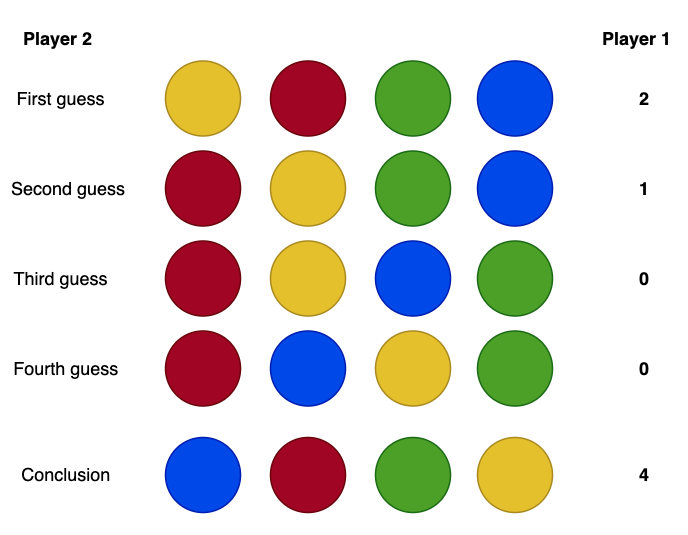

In [39]:
# INSERT YOUR ANSWER HERE
from itertools import combinations

colors = ["red", "blue", "green", "yellow"]
symbols = []
for i in range(4):
    for color in colors:
        symbols.append(Symbol(f"{color}{i}"))

knowledge = And()

# Each color has a position.
for color in colors:
    knowledge.add(Or(
        Symbol(f"{color}0"), Symbol(f"{color}1"),
        Symbol(f"{color}2"), Symbol(f"{color}3")
    ))

# Only one position per color.
for color in colors:
    for i in range(4):
        for j in range(4):
            if i != j:
                knowledge.add(Implication(
                    Symbol(f"{color}{i}"), Not(Symbol(f"{color}{j}"))
                ))

# Only one color per position.
for i in range(4):
    for c1 in colors:
        for c2 in colors:
            if c1 != c2:
                knowledge.add(Implication(
                    Symbol(f"{c1}{i}"), Not(Symbol(f"{c2}{i}"))
                ))

# Helper function to add "exactly N are correct" knowledge
def add_guess_knowledge(guess, n):
    symbols_in_guess = [Symbol(f"{color}{i}") for i, color in enumerate(guess)]
    
    # Generate all combinations of n correct symbols
    correct_combinations = list(combinations(symbols_in_guess, n))
    
    clauses = []
    for correct_combo in correct_combinations:
        # For this combination, these are true and the rest are false
        clause = And()
        for s in symbols_in_guess:
            if s in correct_combo:
                clause.add(s)
            else:
                clause.add(Not(s))
        clauses.append(clause)
    
    # The overall knowledge is that one of these clauses must be true
    knowledge.add(Or(*clauses))

# Guess 1: RBYG -> 1 correct
add_guess_knowledge(["red", "blue", "yellow", "green"], 1)

# Guess 2: BGRY -> 2 correct
add_guess_knowledge(["blue", "green", "red", "yellow"], 2)

# Guess 3: GYRB -> 1 correct
add_guess_knowledge(["green", "yellow", "red", "blue"], 1)


def check_knowledge(knowledge):
    for symbol in symbols:
        if model_check(knowledge, symbol):
            print(f"{symbol}: YES")

check_knowledge(knowledge)

red0: YES
blue0: YES
green0: YES
yellow0: YES
red1: YES
blue1: YES
green1: YES
yellow1: YES
red2: YES
blue2: YES
green2: YES
yellow2: YES
red3: YES
blue3: YES
green3: YES
yellow3: YES


## Exercise 3


Construct a knowledge base and use the model checking on the knowledge base to solve the following logic puzzle.

Four different people, *Gilderoy*, *Pomona*, *Minerva*, and *Horace*, are assigned to four different houses, *Gryffindor*, *Hufflepuff*, *Ravenclaw*, and *Slytherin*.

There is exactly one person in each house, and the following propositions are correct:

1.   *Ponoma* belongs to either the *Hufflepuff* or the *Slytherin* house
2.   *Minerva* doesn't belong to the *Ravenclaw* house
3.   *Horace* belongs to the *Slytherin* house

Please answer the question: Who belongs to which house?

In [40]:
# INSERT YOUR ANSWER HERE
people = ["Gilderoy", "Pomona", "Minerva", "Horace"]
houses = ["Gryffindor", "Hufflepuff", "Ravenclaw", "Slytherin"]
symbols = [Symbol(f"{p}{h}") for p in people for h in houses]

knowledge = And()

# Each person belongs to a house.
for person in people:
    knowledge.add(Or(
        *[Symbol(f"{person}{house}") for house in houses]
    ))

# Only one house per person.
for person in people:
    for h1 in houses:
        for h2 in houses:
            if h1 != h2:
                knowledge.add(Implication(
                    Symbol(f"{person}{h1}"), Not(Symbol(f"{person}{h2}"))
                ))

# Only one person per house.
for house in houses:
    for p1 in people:
        for p2 in people:
            if p1 != p2:
                knowledge.add(Implication(
                    Symbol(f"{p1}{house}"), Not(Symbol(f"{p2}{house}"))
                ))

# Clues
# 1. Pomona belongs to either Hufflepuff or Slytherin
knowledge.add(Or(Symbol("PomonaHufflepuff"), Symbol("PomonaSlytherin")))

# 2. Minerva doesn't belong to Ravenclaw
knowledge.add(Not(Symbol("MinervaRavenclaw")))

# 3. Horace belongs to Slytherin
knowledge.add(Symbol("HoraceSlytherin"))


def check_knowledge(knowledge):
    for symbol in symbols:
        if model_check(knowledge, symbol):
            print(f"{symbol}: YES")

print("Who belongs to which house?")
check_knowledge(knowledge)

Who belongs to which house?
GilderoyRavenclaw: YES
PomonaHufflepuff: YES
MinervaGryffindor: YES
HoraceSlytherin: YES
